In [1]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## define a fixed samplerate

In [2]:
samplerate=200
window=2

## load mass

In [3]:
annotations, signalsMetadata = loadMASSSpindles(masspath,forceSamplerate=samplerate)

In [4]:
annotations.head()

,type,subjectId,startTime,duration,expert,comment,labelerId,samplerate,stopTime,startInd,stopInd
0,spindle,0001,888.569501,0.640579,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,889.210080,177714,177842
1,spindle,0001,905.999757,0.578094,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,906.577851,181200,181316
2,spindle,0001,917.973270,0.847603,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,918.820873,183595,183764
3,spindle,0001,922.319885,0.878845,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,923.198730,184464,184640
4,spindle,0001,939.297141,0.757767,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,940.054908,187859,188011


In [5]:
signalsMetadata.head()

,subjectId,file,channel,duration,samplerate,isOriginalSamplerate,database
0,0001,MASS_0001.pkl,C3-CLE,28956.0,200,False,MASS
1,0002,MASS_0002.pkl,C3-CLE,35016.0,200,False,MASS
2,0003,MASS_0003.pkl,C3-CLE,36760.0,200,False,MASS
3,0004,MASS_0004.pkl,C3-CLE,28004.0,200,False,MASS
4,0005,MASS_0005.pkl,C3-CLE,31244.0,200,False,MASS


## define a fixed feature selection to use

In [6]:
featureSelection=loadPickle("EXT_F1_iteration_7.pkl")
featureSelection.window=window
featureSelection

,characteristic,bandName,window
21,hjortActivity,sigma,2
66,petrosian,broadband,2
22,hjortActivity,theta,2
79,relativePower,beta1,2
29,hjortComplexity,sigma,2


In [7]:
pd.DataFrame({
    'characteristic':['sigmaIndex'],
    'bandName':['broadband'],
    'window':[2]
})

,characteristic,bandName,window
0,sigmaIndex,broadband,2


In [8]:
featureSelection = pd.concat((featureSelection,pd.DataFrame({
    'characteristic':['sigmaIndex'],
    'bandName':['broadband'],
    'window':[2]
}))).reset_index(drop=True)
featureSelection

,characteristic,bandName,window
0,hjortActivity,sigma,2
1,petrosian,broadband,2
2,hjortActivity,theta,2
3,relativePower,beta1,2
4,hjortComplexity,sigma,2
5,sigmaIndex,broadband,2


## load data split
leave-one-subject-out CROSS VALIDATION, two subjects for validation

In [9]:
dataSplits=loadPickle("dataSplits_MASS_debug")
dataSplits

,train,val,test
0,"[0002, 0003, 0004, 0005, 0007, 0008, 0009, 001...","[0006, 0014]",[0001]
1,"[0001, 0003, 0004, 0005, 0006, 0007, 0008, 000...","[0012, 0010]",[0002]
2,"[0002, 0004, 0005, 0006, 0007, 0008, 0009, 001...","[0001, 0012]",[0003]
3,"[0001, 0003, 0005, 0006, 0008, 0009, 0010, 001...","[0002, 0007]",[0004]
4,"[0001, 0002, 0003, 0004, 0006, 0007, 0008, 000...","[0011, 0016]",[0005]
5,"[0001, 0002, 0003, 0004, 0005, 0007, 0008, 000...","[0011, 0016]",[0006]
6,"[0001, 0002, 0003, 0004, 0005, 0006, 0008, 000...","[0010, 0018]",[0007]
7,"[0001, 0002, 0003, 0004, 0005, 0007, 0009, 001...","[0015, 0006]",[0008]
8,"[0001, 0002, 0003, 0004, 0006, 0008, 0010, 001...","[0005, 0007]",[0009]
9,"[0001, 0002, 0003, 0004, 0005, 0006, 0007, 000...","[0011, 0009]",[0010]


## choose the first data split for debugging purposes

In [10]:
trainSplit=dataSplits.train[0]
valSplit=dataSplits.val[0]
testSplit=dataSplits.test[0]

In [11]:
trainSplit

array(['0002', '0003', '0004', '0005', '0007', '0008', '0009', '0010',
       '0011', '0012', '0013', '0015', '0016', '0017', '0018', '0019'],
      dtype=object)

In [12]:
valSplit

array(['0006', '0014'], dtype=object)

In [13]:
testSplit

['0001']

## define annotation criterium
by now we keep the labeler that went trough all the signals

In [14]:
usedAnnotations=annotations[(annotations['type']=='spindle')&(annotations['labelerId']=='0001')]


In [15]:
usedAnnotations[['subjectId','labelerId','duration']].groupby(['subjectId','labelerId']).describe()

duration                                          \
                       count      mean       std       min       25%   
subjectId labelerId                                                    
0001      0001        1044.0  0.822037  0.202792  0.390602  0.675735   
0002      0001        1143.0  0.834582  0.195713  0.414040  0.699173   
0003      0001         143.0  0.690269  0.149652  0.460907  0.585900   
0004      0001         253.0  0.829708  0.224842  0.492157  0.667923   
0005      0001         341.0  0.706104  0.131805  0.425751  0.613243   
0006      0001         150.0  0.761306  0.143614  0.492157  0.679642   
0007      0001         912.0  0.892692  0.226504  0.425751  0.730423   
0008      0001         385.0  0.846882  0.227884  0.441376  0.695267   
0009      0001         814.0  0.923970  0.216783  0.468719  0.773392   
0010      0001         795.0  0.815081  0.190663  0.402321  0.687454   
0011      0001         606.0  0.923982  0.222469  0.503876  0.773384   
0012      0001         709.0  0.836528  0.180787  0.437469  0.706985   
0013      0001         698.0  0.910960  0.245084  0.437477  0.742142   
0014      0001         713.0  0.805534  0.205166  0.406227  0.671829   
0015      0001          97.0  0.739281  0.106173  0.519501  0.671829   
0016      0001         452.0  0.806943  0.210937  0.335915  0.640587   
0017      0001         470.0  0.802766  0.155081  0.437469  0.694296   
0018      0001        1164.0  0.844465  0.185415  0.421852  0.722610   
0019      0001         315.0  0.770511  0.129903  0.453094  0.687454   

                                                   
                          50%       75%       max  
subjectId labelerId                                
0001      0001       0.796822  0.945251  1.839722  
0002      0001       0.816353  0.937439  1.820198  
0003      0001       0.648399  0.775341  1.160080  
0004      0001       0.785103  0.945251  1.675674  
0005      0001       0.699173  0.781197  1.195236  
0006      0001       0.749954  0.847603  1.480377  
0007      0001       0.867134  1.003845  2.042839  
0008      0001       0.800728  0.937439  1.925659  
0009      0001       0.890568  1.027275  1.882690  
0010      0001       0.773392  0.921814  1.847542  
0011      0001       0.890564  1.042900  2.015495  
0012      0001       0.808548  0.956970  1.495995  
0013      0001       0.871036  1.026300  2.117058  
0014      0001       0.773392  0.906197  2.218605  
0015      0001       0.722610  0.808540  1.011650  
0016      0001       0.773384  0.925720  1.679581  
0017      0001       0.781200  0.890570  1.644424  
0018      0001       0.824165  0.941345  1.882690  
0019      0001       0.757767  0.839790  1.359291

## model fitting

In [16]:
def eval_F1(preds, y):
    y = y.get_label()
    score=F1(y,preds)
    return 'anti-F1', 1-score

In [17]:
signalsMetadata

,subjectId,file,channel,duration,samplerate,isOriginalSamplerate,database
0,0001,MASS_0001.pkl,C3-CLE,28956.0,200,False,MASS
1,0002,MASS_0002.pkl,C3-CLE,35016.0,200,False,MASS
2,0003,MASS_0003.pkl,C3-CLE,36760.0,200,False,MASS
3,0004,MASS_0004.pkl,C3-CLE,28004.0,200,False,MASS
4,0005,MASS_0005.pkl,C3-CLE,31244.0,200,False,MASS
5,0006,MASS_0006.pkl,C3-CLE,28990.0,200,False,MASS
6,0007,MASS_0007.pkl,C3-CLE,28302.0,200,False,MASS
7,0008,MASS_0008.pkl,C3-CLE,26846.0,200,False,MASS
8,0009,MASS_0009.pkl,C3-CLE,29834.0,200,False,MASS
9,0010,MASS_0010.pkl,C3-CLE,25930.0,200,False,MASS


In [18]:
#Features
trainFeatures=loadFeatureMatrix(trainSplit,featureSelection,signalsMetadata,samplerate,datapath)
valFeatures=loadFeatureMatrix(valSplit,featureSelection,signalsMetadata,samplerate,datapath)
#Labels
trainLabels=loadLabelsVector(trainSplit,usedAnnotations,signalsMetadata,samplerate)
valLabels=loadLabelsVector(valSplit,usedAnnotations,signalsMetadata,samplerate)


In [19]:
trainFeatures.shape

(95402800, 6)

In [20]:
trainSplit

array(['0002', '0003', '0004', '0005', '0007', '0008', '0009', '0010',
       '0011', '0012', '0013', '0015', '0016', '0017', '0018', '0019'],
      dtype=object)

In [21]:
aux=np.array([])
for trainSample in trainSplit:
    aux=np.append(aux,loadFeature(window,trainSample,"petrosian","broadband",str(200),datapath+'/MASS/features'))

In [22]:
len(aux)

95402800

In [23]:
sum(trainFeatures[:,1]==aux)

95402800

In [24]:
aux=np.array([])
for trainSample in trainSplit:
    thisDuration=signalsMetadata[signalsMetadata.subjectId==trainSample].duration.iloc[0]
    thisLabels=excerptAnnotationsToLabels(usedAnnotations[usedAnnotations.subjectId==trainSample],int(thisDuration*200)) # process all annotations of a given subject
    aux=np.append(aux,thisLabels)

In [25]:
len(aux)

95402800

In [26]:
len(trainLabels)

95402800

In [27]:
sum(trainLabels==aux)

95402800

In [28]:
usedAnnotations.head(10)

,type,subjectId,startTime,duration,expert,comment,labelerId,samplerate,stopTime,startInd,stopInd
0,spindle,0001,888.569501,0.640579,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,889.210080,177714,177842
1,spindle,0001,905.999757,0.578094,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,906.577851,181200,181316
2,spindle,0001,917.973270,0.847603,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,918.820873,183595,183764
3,spindle,0001,922.319885,0.878845,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,923.198730,184464,184640
4,spindle,0001,939.297141,0.757767,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,940.054908,187859,188011
5,spindle,0001,949.820501,0.574181,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,950.394682,189964,190079
6,spindle,0001,969.057502,0.828079,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,969.885581,193812,193977
7,spindle,0001,978.938143,0.472626,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,979.410769,195788,195882
8,spindle,0001,981.660014,0.710892,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,982.370906,196332,196474
9,spindle,0001,993.992526,0.980408,E1,"<Event channel=""EEG C3-LER"" groupName=""spindle...",0001,200,994.972934,198799,198995


In [29]:
n_jobs=8 # paralelization parameter for xgboost (keep it 8 as maximum)
learning_rate=0.3
subsample=0.7
compensate=2

#Train the models
print(sum(1-trainLabels)/sum(trainLabels))
xgb_model = xgb.XGBClassifier(n_jobs=n_jobs,scale_pos_weight=compensate, subsample=subsample).fit(trainFeatures, trainLabels, early_stopping_rounds=3, eval_metric=eval_F1,eval_set=[(valFeatures,valLabels)])

#val predictions and objective function definition
valPredictions=xgb_model.predict(valFeatures, ntree_limit=xgb_model.best_ntree_limit)
valF1=F1(valLabels,valPredictions)


59.600178238060245


c:\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.45744	validation_0-anti-F1:0.96980
[1]	validation_0-logloss:0.32628	validation_0-anti-F1:0.96175
[2]	validation_0-logloss:0.24346	validation_0-anti-F1:0.95211
[3]	validation_0-logloss:0.18801	validation_0-anti-F1:0.94069
[4]	validation_0-logloss:0.14977	validation_0-anti-F1:0.92800
[5]	validation_0-logloss:0.12277	validation_0-anti-F1:0.91419
[6]	validation_0-logloss:0.10344	validation_0-anti-F1:0.89977
[7]	validation_0-logloss:0.08954	validation_0-anti-F1:0.88536
[8]	validation_0-logloss:0.07946	validation_0-anti-F1:0.87198
[9]	validation_0-logloss:0.07209	validation_0-anti-F1:0.85956
[10]	validation_0-logloss:0.06676	validation_0-anti-F1:0.84817
[11]	validation_0-logloss:0.06287	validation_0-anti-F1:0.83878
[12]	validation_0-logloss:0.06007	validation_0-anti-F1:0.83191
[13]	validation_0-logloss:0.05795	validation_0-anti-F1:0.82541
[14]	validation_0-logloss:0.05644	validation_0-anti-F1:0.82007
[15]	validation_0-logloss:0.05536	validation_0-anti-F1:0.81663
[1

c:\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [30]:
F1(valLabels,valPredictions)

0.3185766726951426

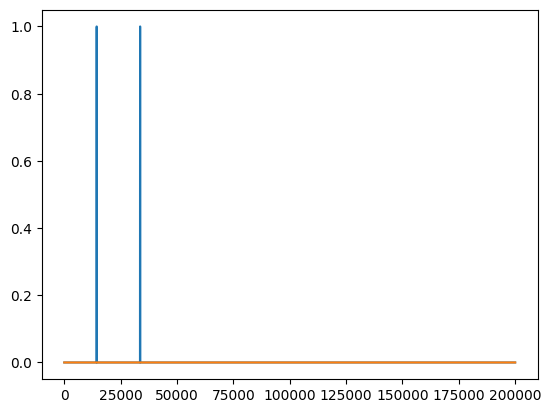

In [31]:
plt.plot(valLabels[int(2*10**6):int(2.2*10**6)])
plt.plot(valPredictions[int(2*10**6):int(2.2*10**6)])

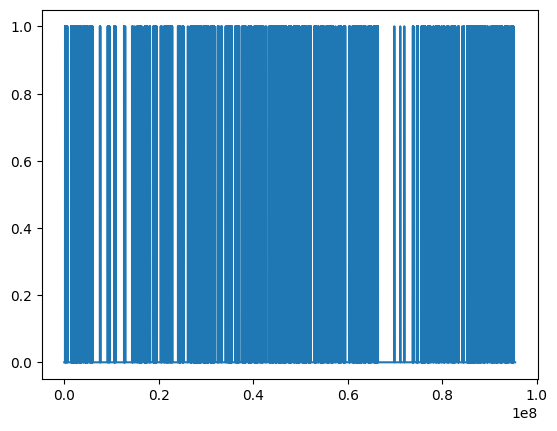

In [32]:
trainPredictions=xgb_model.predict(trainFeatures)
plt.plot(trainPredictions)


In [33]:
valProcessed=labelingProcess(valPredictions,0.3,0.3,200,verbose=1)

Number of raw candidates: 2432
Number of detections: 467


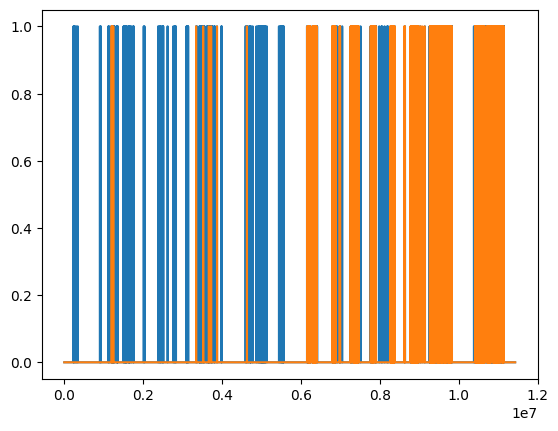

In [34]:
plt.plot(valLabels)
plt.plot(valProcessed)

In [35]:
F1(valLabels,valProcessed)

0.33268715593043574

In [36]:
trainProcessed=labelingProcess(trainPredictions,0.1,0.3,200,verbose=1)

Number of raw candidates: 10839
Number of detections: 1819


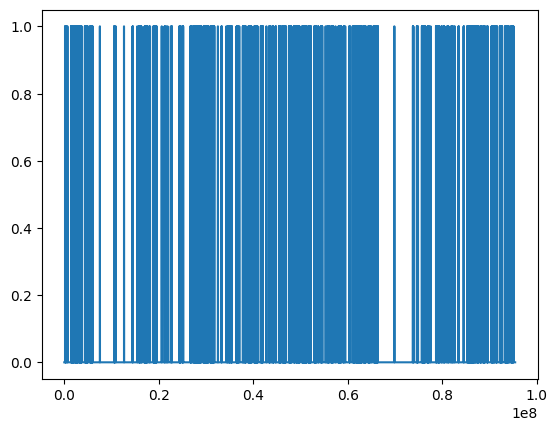

In [37]:
plt.plot(trainProcessed)

In [38]:
F1(trainLabels,trainProcessed)

0.1470447948749795

In [39]:
F1(trainLabels,trainPredictions)

0.14856440964225395

In [40]:
np.sum(trainPredictions)/len(trainPredictions)

0.00363758715677108

In [41]:
np.sum(trainLabels)/len(trainLabels)

0.016501601630140833

In [42]:
print("number of validation labels")
len(usedAnnotations[usedAnnotations.subjectId.isin(valSplit)])

number of validation labels


863